In [2]:
from rw_tokenize import *
from clustering_functions import *
import numpy as np
import matplotlib.pyplot as plt
#import gensim.models
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering


In [3]:
retracted = get_driver()

doc_cursor = retracted.find(
    {"text":{"$exists":1}},
    {"text":1, "abstract":1}
)

In [4]:
texts = []
ids = []
abstracts = []
for doc in doc_cursor:
    texts.append(doc["text"])
    abstracts.append(doc["abstract"])
    ids.append(doc["_id"])

# Full Article

In [5]:
params = {"ngram_range":(1,2),
#           "stop_words":"english",
          "token_pattern":r"\b[a-z][a-z]+\b",
          "max_df":0.9,
          "min_df":0.01}

vectorizer = CountVectorizer(**params)
topicker=PCA(n_components=50)

text_cleaned = [clean(text) for text in texts]

text_word_data = (vectorizer.fit_transform(text_cleaned).toarray()) >= 1
text_topic_data = topicker.fit_transform(text_word_data)

In [6]:
fulltext_model = view_dbscan(text_topic_data, 30, 0.01,0.01)

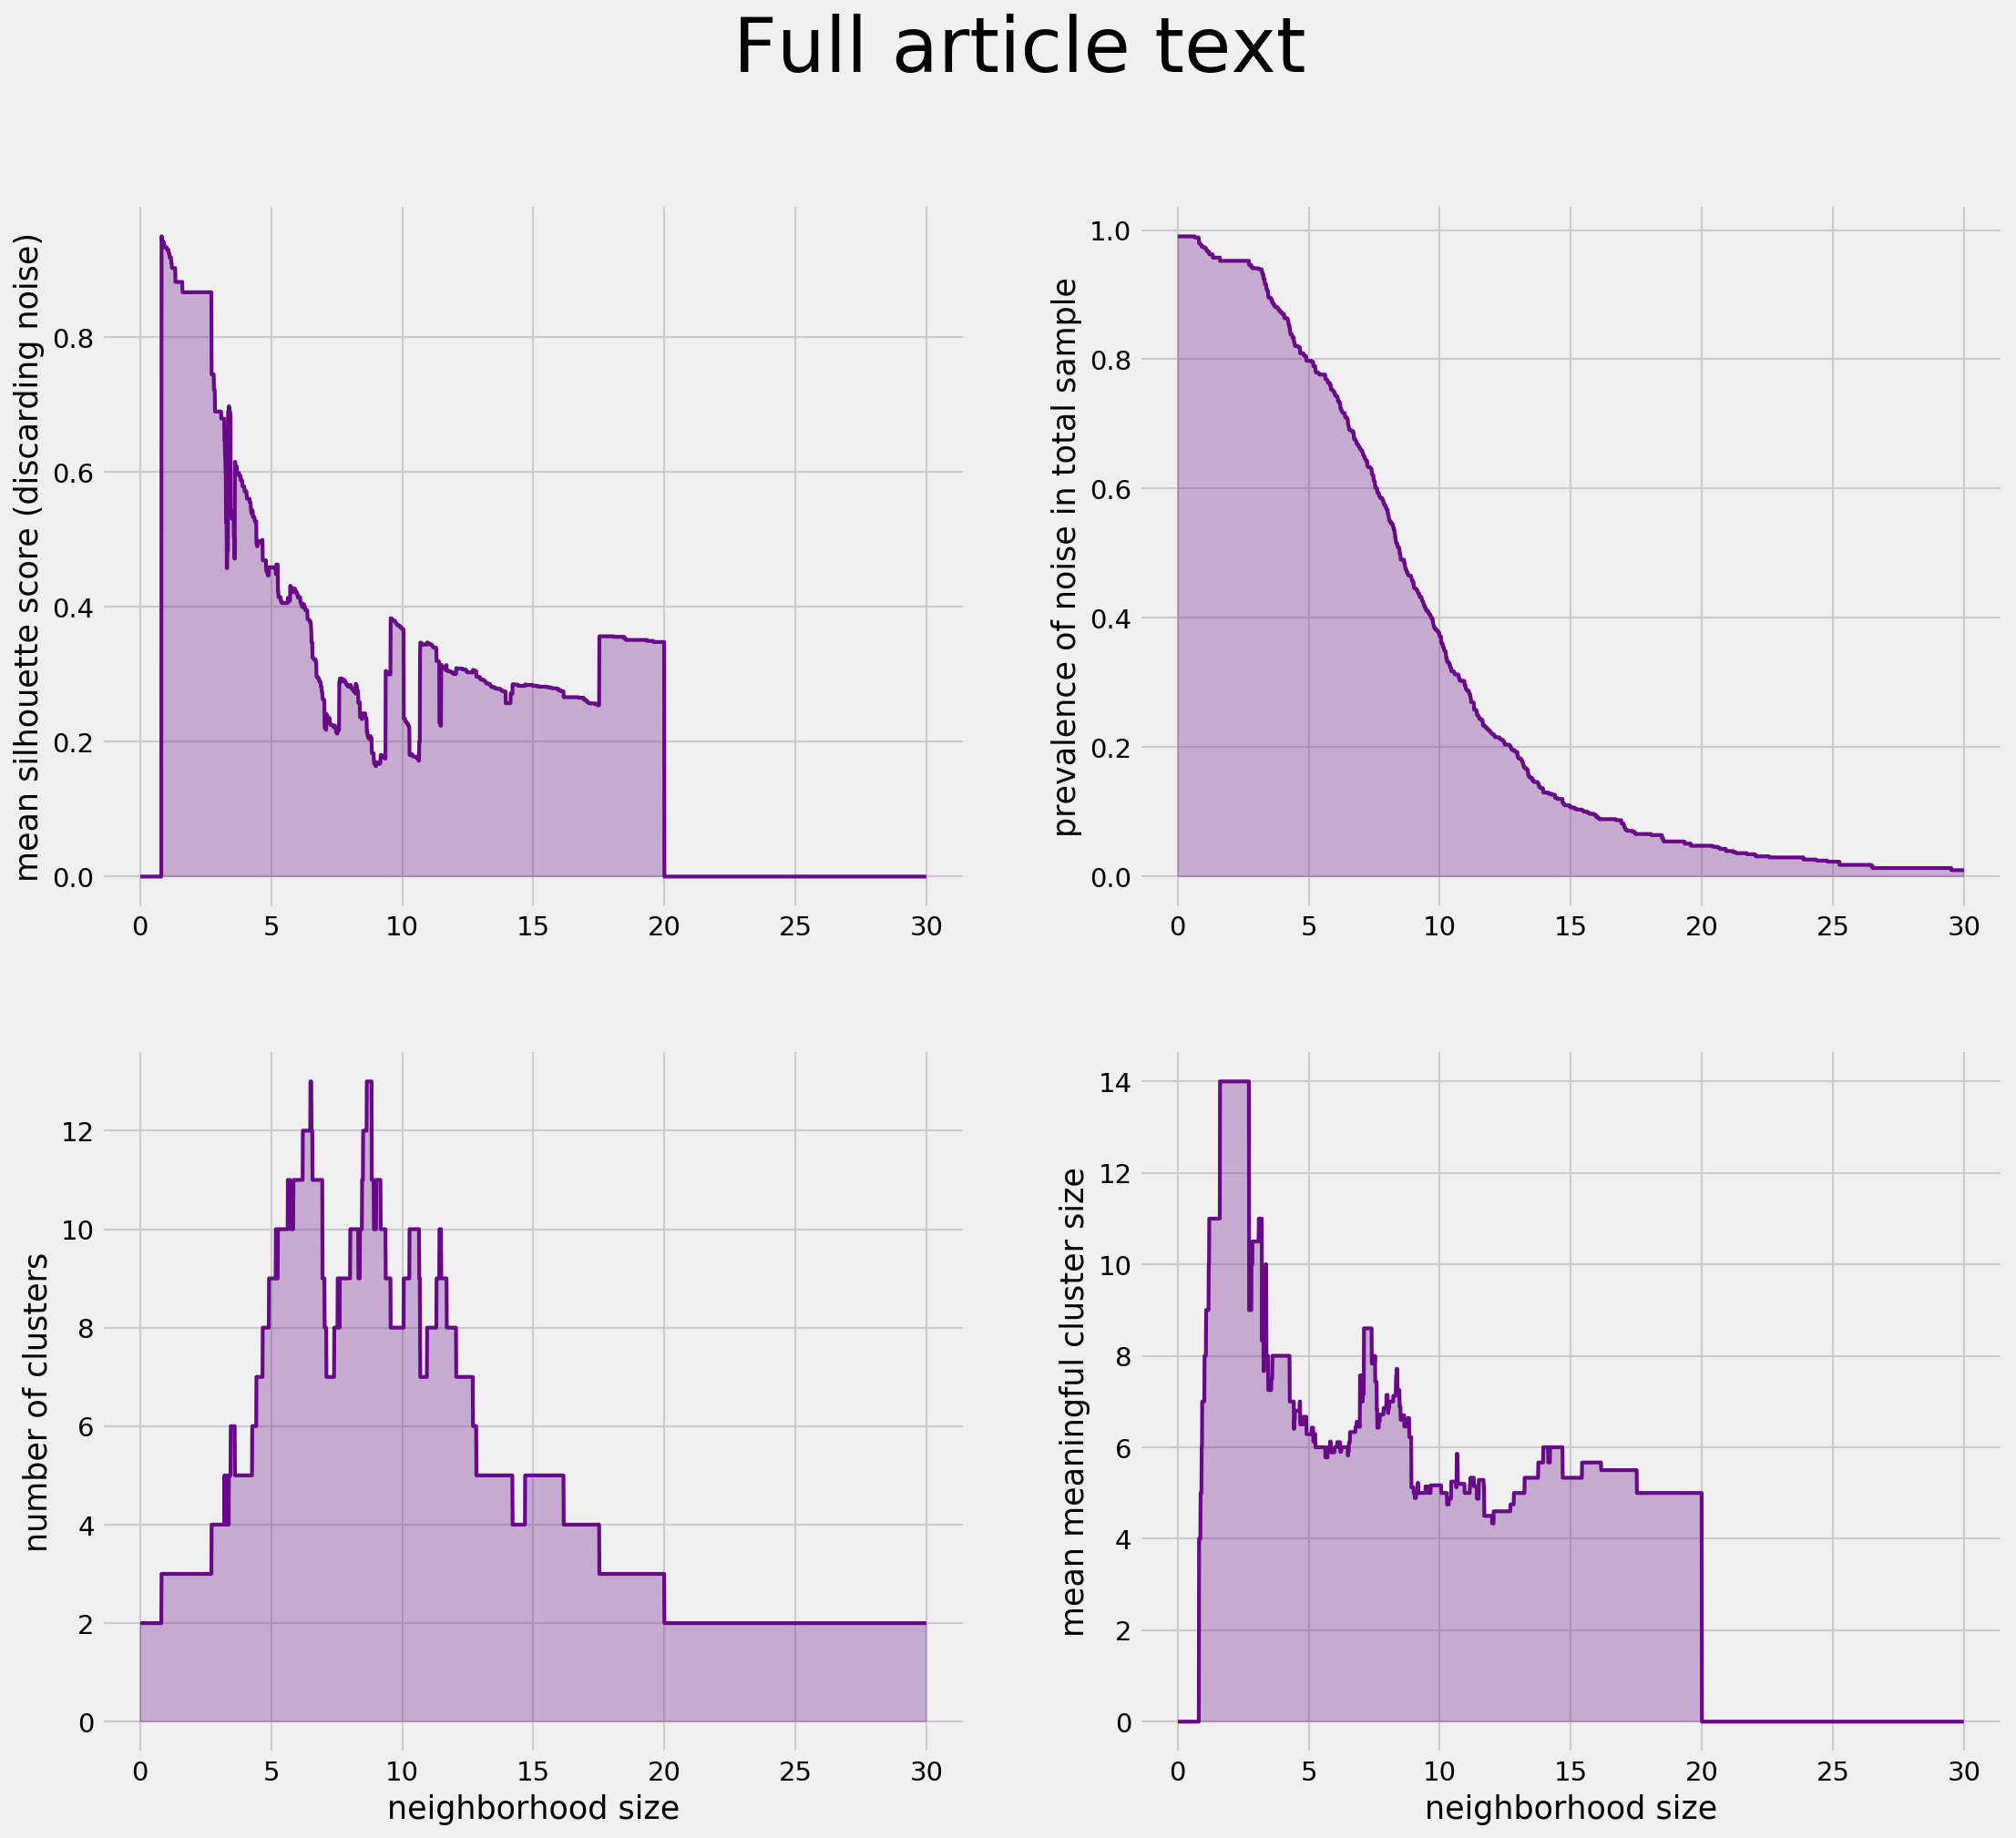

In [7]:
plot_exploration(**fulltext_model, title="Full article text")

### Model

In [8]:
np.array(fulltext_model["k_clusters"]).argmax()

649

In [9]:
model=DBSCAN(eps=8.39, min_samples=4)
text_labels= model.fit_predict(text_topic_data)

In [10]:
tsne = TSNE(n_components=2, perplexity=10, n_iter=5000)
text_ne = tsne.fit_transform(text_topic_data)

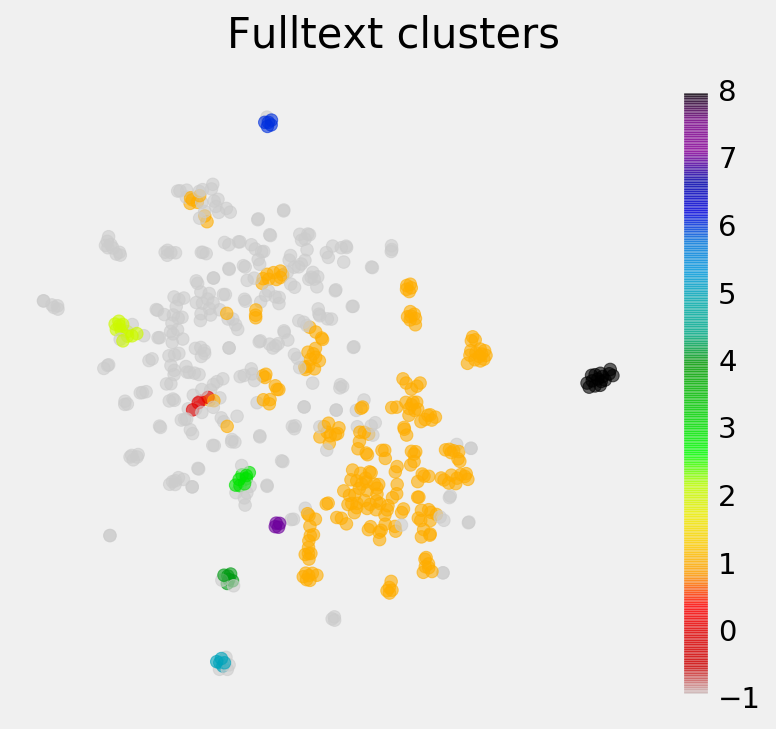

In [11]:
plot_tsne(text_ne, text_labels, title="Fulltext clusters")

In [12]:
for label in set(labels):
    mask = labels == label
    print("Cluster {} has {} documents.".format(label, sum(mask)))

NameError: name 'labels' is not defined

def predict_cluster( text ):
    texts = [clean(text)]
    word_data = vectorizer.transform(texts).toarray()
    topic_data = topicker.fit_transform(word_data)
    group = model.predict(topic_data)[0]

In [ ]:
def get_group_text(group_id):
    mask = labels == group_id
    return [texts[i] for i, e in enumerate(mask) if e]

In [ ]:
get_group_text(7)
for doc in get_group_text(7):
    print(doc[:100])

# Abstract Exploration

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
params = {"ngram_range":(1,3),
#           "stop_words":"english",
          "token_pattern":r"\b[a-z][a-z]+\b",
          "max_df":0.9,
          "min_df":0.01}

vectorizer = TfidfVectorizer(**params)
topicker=PCA(n_components=50)

clean_abstracts = [clean(a) for a in abstracts]
abs_word_data = vectorizer.fit_transform(clean_abstracts).toarray()
abs_topic_data = topicker.fit_transform(abs_word_data)

In [ ]:
abstract_data = view_model(abs_topic_data, 0.6)

In [ ]:
plot_exploration(**abstract_data, title="Abstract neighborhood plots")

In [ ]:
model=DBSCAN(eps=0.376, min_samples=4)
abs_labels = model.fit_predict(abs_topic_data)

In [ ]:
tsne = TSNE(n_components=2, perplexity=100, n_iter=10000)
abs_X_ne = tsne.fit_transform(abs_topic_data)

In [ ]:
np.array(abstract_data["k_clusters"]).argmax()

In [ ]:
plot_tsne(abs_X_ne, abs_labels, title="Abstract groups")

In [ ]:
plot_tsne(abs_X_ne, text_labels, title="Text groups")

## Profiling

In [ ]:
profile_labels(abs_labels)

In [ ]:
profile_labels(text_labels)

In [ ]:
get_clusters(text_labels, ids)[7]

In [ ]:
abstract_clusters = get_clusters(abs_labels, ids)
text_clusters = get_clusters(text_labels, ids)
for a_lbl, a_ids in abstract_clusters.items():
    for t_lbl, t_ids in text_clusters.items():
        if a_ids == t_ids:
            print("Abstract cluster {} is text cluster {}.".format(a_lbl, t_lbl))

In [ ]:
doc_cursor = retracted.find(
    {"_id":{"$in":abstract_clusters[18]}},
    {"title":1, "journal":1}
)

In [ ]:
doc_cursor = retracted.find(
    {"_id":{"$in":abstract_clusters[17]}},
    {"title":1, "journal":1, "authors":1}
)
list(doc_cursor)

In [ ]:
doc_cursor = retracted.find(
    {"_id":{"$in":abstract_clusters[18]}},
    {"authors":1}
)
list(doc_cursor)

In [ ]:
doc_cursor = retracted.find(
    {"journal":{"$regex":"^Journal of Lipid Research"}},
    {"title":1, "journal":1, "authors":1}
)
len(list(doc_cursor))

In [ ]:
doc_cursor = retracted.find(
    {"journal":{"$regex":"^Acta Crystallographica"}, "_id":{"$nin":abstract_clusters[18]}},
    {"authors":1}
)
list(doc_cursor)

# Silhouette scores of rejected culstering algorithms

## Agglomerative clustering

In [ ]:
for k in range(2,75):
    plt.figure(dpi=120, figsize=(8,6))
    ax1 = plt.gca()
    km = AgglomerativeClustering(n_clusters=k)
    km.fit(topic_data)
    labels = km.labels_
    silhouette_avg = silhouette_score(topic_data, labels)
    print("For n_clusters =", k,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(topic_data, labels)

    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.jet(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    
    ax1.set_title("The silhouette plot for {} clusters.".format(k))
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])